In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftn, ifftn, fftshift, ifftshift
import time

import glob
import os

import waveorder as wo
from waveorder.io.writer import WaveorderWriter
from waveorder.io.reader import WaveorderReader
import zarr
import pickle


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


In [2]:
n_media       = 1.518                   # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 100                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 1.4                 # illumination NA of the condenser
N_defocus     = 40                   # number of defocus images
N_channel     = 4                   # number of Polscope channels
N_pattern     = 9
z_step        = 0.25               # z_step of the stack
z_defocus     = (np.r_[:N_defocus]-0)*z_step
ps            = 3.45*2/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = False                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'global'         # background correction method for Polscope recon (does not affect phase)

output_path   = 'Full_FOV_process_test_new_pipeline'      # output image path

use_gpu       = True
gpu_id        = 2

reg_inc       = np.array([2.5, 2.5, 40, 40, 80, 80, 40])*1  # regularization for 3D orientation recon
reg_ret_pr    = 1e-1                                    # principle retardance regularization


### Calibration and data loading

Calibrated source field:
[[ 0.6601+0.j    ]
 [-0.1183+0.7418j]]
Calibrated instrument matrix:
[[ 0.2481  0.2444 -0.    ]
 [ 0.2543  0.0031  0.2292]
 [ 0.2455 -0.2439 -0.0009]
 [ 0.2521 -0.0036 -0.2284]]


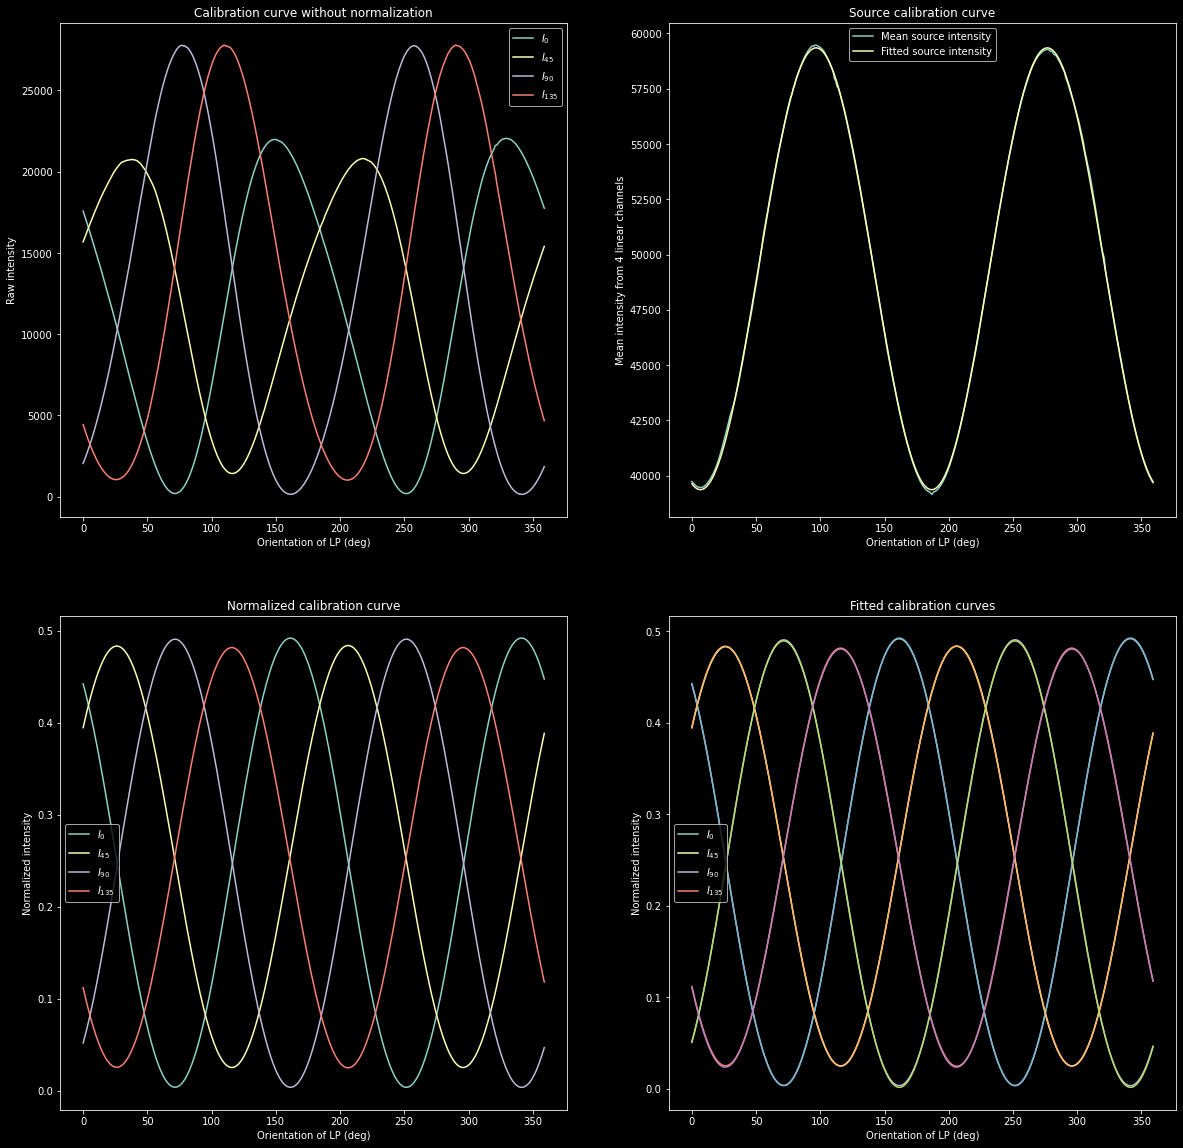

In [3]:
# Load data and bg

uPTI_file_name = 'Cardiomyocytes_infected_1_raw.zarr'
reader = WaveorderReader(uPTI_file_name, 'zarr')
I_meas_full = np.transpose(reader.get_array(0),(0,1,3,4,2))
I_bg_full = np.squeeze(np.transpose(reader.get_array(1),(0,1,3,4,2)))

# Load calibration

uPTI_file = zarr.open(uPTI_file_name, mode='a')
I_cali_mean = np.array(uPTI_file.I_cali_mean)


# source polarization, instrument matrix calibration
E_in, A_matrix, I_cali_mean = wo.instrument_matrix_and_source_calibration(I_cali_mean, handedness = 'RCP')


### Creating processing list for sub-FOV 

In [4]:
N_full = 1024
M_full = 1224
overlapping_range = [20,100]
max_image_size = [300,300]

N_edge, N_space, M_space = wo.generate_FOV_splitting_parameters((N_full, M_full), overlapping_range, max_image_size)

Optimal number of overlapping is 24 pixels
The corresponding maximal N_space is 250 pixels
The corresponding maximal M_space is 240 pixels


In [5]:
# Create sub-FOV list

Ns = N_space + N_edge
Ms = M_space + N_edge

ns, ms = wo.generate_sub_FOV_coordinates((N_full, M_full), (N_space, M_space), (N_edge,N_edge))

os.system('mkdir '+output_path)

Last pixel in (y,x) dimension processed is (1024, 1224)


0

### Initialize the processing (Source, OTF, ...)

In [6]:
# DPC + BF illumination

xx, yy, fxx, fyy = wo.gen_coordinate((Ns, Ms), ps)



rotation_angle=[180-22.5, 225-22.5, 270-22.5, 315-22.5, 0-22.5, 45-22.5, 90-22.5, 135-22.5]
sector_angle = 45

Source_BF = wo.gen_Pupil(fxx, fyy, NA_obj/n_media/2, lambda_illu/n_media)
Source = wo.gen_sector_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media, sector_angle, rotation_angle)
Source.append(Source_BF)
Source = np.array(Source)


    
Source_PolState = np.zeros((len(Source),2), complex)


for i in range(len(Source)):
    Source_PolState[i,0] = E_in[0]
    Source_PolState[i,1] = E_in[1]
    
    
# Reconstruct parameters

setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, \
                                n_media=n_media, cali=cali, bg_option=bg_option, \
                                A_matrix = A_matrix, \
                                phase_deconv='3D', inc_recon='3D', \
                                illu_mode='Arbitrary', Source = Source, \
                                Source_PolState=Source_PolState, \
                                use_gpu=use_gpu, gpu_id=gpu_id)

In [7]:
import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

### Convert intensity to Stokes

In [8]:
# Compute background-removed Stokes vectors
    
S_image_recon = setup.Stokes_recon(I_meas_full[:,:,:,:,::-1])
S_bg_recon = setup.Stokes_recon(I_bg_full)


S_image_tm_full = np.zeros_like(S_image_recon)
S_image_tm_full[0] = S_image_recon[0]/S_bg_recon[0,:,:,:,np.newaxis] -1
S_image_tm_full[1] = S_image_recon[1]/S_bg_recon[0,:,:,:,np.newaxis] - S_bg_recon[1,:,:,:,np.newaxis]*S_image_recon[0]/S_bg_recon[0,:,:,:,np.newaxis]**2
S_image_tm_full[2] = S_image_recon[2]/S_bg_recon[0,:,:,:,np.newaxis] - S_bg_recon[2,:,:,:,np.newaxis]*S_image_recon[0]/S_bg_recon[0,:,:,:,np.newaxis]**2


### Writer setup

In [9]:

uPTI_file_name = 'uPTI_subFOVs.zarr'
writer = WaveorderWriter(output_path, hcs=False, hcs_meta=None, verbose=True)
writer.create_zarr_root(uPTI_file_name)

data_shape = (1,9,N_defocus,int(Ns),int(Ms))
chunk_size = (1,1,1,int(Ns),int(Ms))
chan_names = ['f_tensor0r', 'f_tensor0i', 'f_tensor1c','f_tensor1s','f_tensor2c','f_tensor2s', 'f_tensor3', 'mat_map0', 'mat_map1']

# append stitching parameters
row_list = (ns//N_space).astype('int')
column_list = (ms//M_space).astype('int')
uPTI_file = zarr.open(os.path.join(output_path,uPTI_file_name), mode='a')
uPTI_file.create_dataset('row_list', data = row_list)
uPTI_file.create_dataset('column_list', data = column_list)
uPTI_file.create_dataset('overlap', data = N_edge)

Creating new zarr store at Full_FOV_process_test_new_pipeline/uPTI_subFOVs.zarr


<zarr.core.Array '/overlap' () int64>

### Patch-wise processing

In [10]:
t0 = time.time()

for ll in range(len(ns)):
    
    position = ll
    writer.init_array(position, data_shape, chunk_size, chan_names, position_name=None, overwrite=True)
    n_start = [int(ns[ll]), int(ms[ll])]
    S_image_tm = S_image_tm_full[:,:,n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms,:]
    
    f_tensor = setup.scattering_potential_tensor_recon_3D_vec(S_image_tm, reg_inc=reg_inc, cupy_det=True)
    _, _, _, mat_map = setup.scattering_potential_tensor_to_3D_orientation(f_tensor, S_image_tm,
                                                                            material_type='unknown', verbose=False,
                                                                            reg_ret_pr = reg_ret_pr, itr=60, step_size=0.1,
                                                                            fast_gpu_mode=True)
    
    uPTI_array = np.transpose(np.concatenate((f_tensor, mat_map),axis=0)[np.newaxis,...],(0,1,4,2,3)) # dimension (T, C, Z, Y, X)
    writer.write(uPTI_array, p=ll)
    print('Finish process at (y, x) = (%d, %d), elapsed time: %.2f'%(ns[ll], ms[ll], time.time()-t0))

    

Creating and opening subgroup Row_0/Col_0/Pos_000
Finished preprocess, elapsed time: 12.47
Finished reconstruction, elapsed time: 13.50
Finish optic sign estimation, elapsed time: 79.72
Opening subgroup Row_0/Col_0/Pos_000
Finish process at (y, x) = (0, 0), elapsed time: 106.31
Creating and opening subgroup Row_0/Col_1/Pos_001
Finished preprocess, elapsed time: 12.87
Finished reconstruction, elapsed time: 13.22
Finish optic sign estimation, elapsed time: 58.63
Opening subgroup Row_0/Col_1/Pos_001
Finish process at (y, x) = (0, 240), elapsed time: 191.03
Creating and opening subgroup Row_0/Col_2/Pos_002
Finished preprocess, elapsed time: 13.29
Finished reconstruction, elapsed time: 13.65
Finish optic sign estimation, elapsed time: 58.68
Opening subgroup Row_0/Col_2/Pos_002
Finish process at (y, x) = (0, 480), elapsed time: 276.12
Creating and opening subgroup Row_0/Col_3/Pos_003
Finished preprocess, elapsed time: 12.71
Finished reconstruction, elapsed time: 13.07
Finish optic sign estim

In [11]:
import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

### Image stitching

In [12]:
# save stitched results

uPTI_file_name = 'uPTI_subFOVs.zarr'

reader = WaveorderReader(os.path.join(output_path, uPTI_file_name), 'zarr')
uPTI_file = zarr.open(os.path.join(output_path,uPTI_file_name), mode='a')

coord_list = (np.array(uPTI_file.row_list), np.array(uPTI_file.column_list))
overlap = (int(np.array(uPTI_file.overlap)),int(np.array(uPTI_file.overlap)))
file_loading_func = lambda x: np.transpose(reader.get_array(x),(3,4,0,1,2))

img_normalized, ref_stitch = wo.image_stitching(coord_list, overlap, file_loading_func, gen_ref_map=True, ref_stitch=None)




Processed positions (1 / 20), elapsed time: 6.08
Processed positions (2 / 20), elapsed time: 11.03
Processed positions (3 / 20), elapsed time: 16.38
Processed positions (4 / 20), elapsed time: 21.51
Processed positions (5 / 20), elapsed time: 27.10
Processed positions (6 / 20), elapsed time: 31.80
Processed positions (7 / 20), elapsed time: 36.22
Processed positions (8 / 20), elapsed time: 40.39
Processed positions (9 / 20), elapsed time: 44.82
Processed positions (10 / 20), elapsed time: 49.47
Processed positions (11 / 20), elapsed time: 54.68
Processed positions (12 / 20), elapsed time: 59.40
Processed positions (13 / 20), elapsed time: 64.56
Processed positions (14 / 20), elapsed time: 69.45
Processed positions (15 / 20), elapsed time: 74.22
Processed positions (16 / 20), elapsed time: 79.66
Processed positions (17 / 20), elapsed time: 84.31
Processed positions (18 / 20), elapsed time: 87.97
Processed positions (19 / 20), elapsed time: 92.93
Processed positions (20 / 20), elapsed ti

In [13]:
writer = WaveorderWriter(output_path, hcs=False, hcs_meta=None, verbose=True)
writer.create_zarr_root('uPTI_stitched.zarr')
chan_names = ['f_tensor0r', 'f_tensor0i', 'f_tensor1c','f_tensor1s','f_tensor2c','f_tensor2s', 'f_tensor3', 'mat_map0', 'mat_map1']

uPTI_array_stitched = np.transpose(img_normalized,(2,3,4,0,1))
position = 0
data_shape_stitched = uPTI_array_stitched.shape
chunk_size_stitched = (1,1,1)+uPTI_array_stitched.shape[3:]
writer.init_array(position, data_shape_stitched, chunk_size_stitched, chan_names, position_name='Stitched_f_tensor', overwrite=True)
writer.write(uPTI_array_stitched, p=position)

Creating new zarr store at Full_FOV_process_test_new_pipeline/uPTI_stitched.zarr
Creating and opening subgroup Row_0/Col_0/Stitched_f_tensor
Opening subgroup Row_0/Col_0/Stitched_f_tensor


### Data analysis with stitched images

In [14]:
# load the stitched scattering potential tensor

Nc = 1024
Mc = 1224
n_start = [0, 0]


uPTI_file_name = 'uPTI_stitched.zarr'
reader = WaveorderReader(os.path.join(output_path, uPTI_file_name), 'zarr')
uPTI_array_stitched = np.transpose(np.squeeze(np.array(reader.get_zarr(0)[...,n_start[0]:n_start[0]+Nc, n_start[1]:n_start[1]+Mc])),(0,2,3,1))
f_tensor = uPTI_array_stitched[:7]
mat_map = uPTI_array_stitched[7:]


In [15]:
# compute the physical properties from the scattering potential tensor

retardance_pr_p, azimuth_p, theta_p = wo.scattering_potential_tensor_to_3D_orientation_PN(f_tensor, material_type='positive', reg_ret_pr = reg_ret_pr)
retardance_pr_n, azimuth_n, theta_n = wo.scattering_potential_tensor_to_3D_orientation_PN(f_tensor, material_type='negative', reg_ret_pr = reg_ret_pr)
retardance_pr = np.array([retardance_pr_p,retardance_pr_n])
azimuth = np.array([azimuth_p,azimuth_n])
theta = np.array([theta_p, theta_n])

p_mat_map = wo.optic_sign_probability(mat_map, mat_map_thres=0.04)
phase = wo.phase_inc_correction(f_tensor[0], retardance_pr[0], theta[0])
phase_PT, absorption_PT, retardance_pr_PT = [wo.unit_conversion_from_scattering_potential_to_permittivity(SP_array, lambda_illu, n_media=n_media, imaging_mode = '3D') 
                                             for SP_array in [phase, f_tensor[1].copy(), retardance_pr]]
retardance_pr_PT = np.array([((-1)**i)*wo.wavelet_softThreshold(((-1)**i)*retardance_pr_PT[i], 'db8', 0.0002, level=1) for i in range(2)])
orientation_continuity_map = wo.orientation_3D_continuity_map(azimuth[0], theta[0], psz_ps_ratio=z_step/ps, avg_px_size=10, reg_ret_pr=1e-1)
retardance_pr_PT*=orientation_continuity_map[np.newaxis,...]

In [16]:
# save results to zarr array
writer = WaveorderWriter(output_path, hcs=False, hcs_meta=None, verbose=True)
writer.create_zarr_root('uPTI_physical.zarr')

position = 0
chan_names_phys = ['Phase3D', 'Retardance3D', 'Orientation', 'Inclination', 'Optic_sign']
phys_data_array = np.transpose(np.array([phase_PT, np.abs(retardance_pr_PT[0]), azimuth[0], theta[0], p_mat_map]),(0,3,1,2))[np.newaxis,...]
data_shape_phys = phys_data_array.shape
chunk_size_phys = (1,1,1)+phys_data_array.shape[3:]
dtype = 'float32'
writer.init_array(position, data_shape_phys, chunk_size_phys, chan_names_phys, dtype, position_name='Stitched_physical', overwrite=True)
writer.write(phys_data_array, p=position)

Creating new zarr store at Full_FOV_process_test_new_pipeline/uPTI_physical.zarr
Creating and opening subgroup Row_0/Col_0/Stitched_physical
Opening subgroup Row_0/Col_0/Stitched_physical


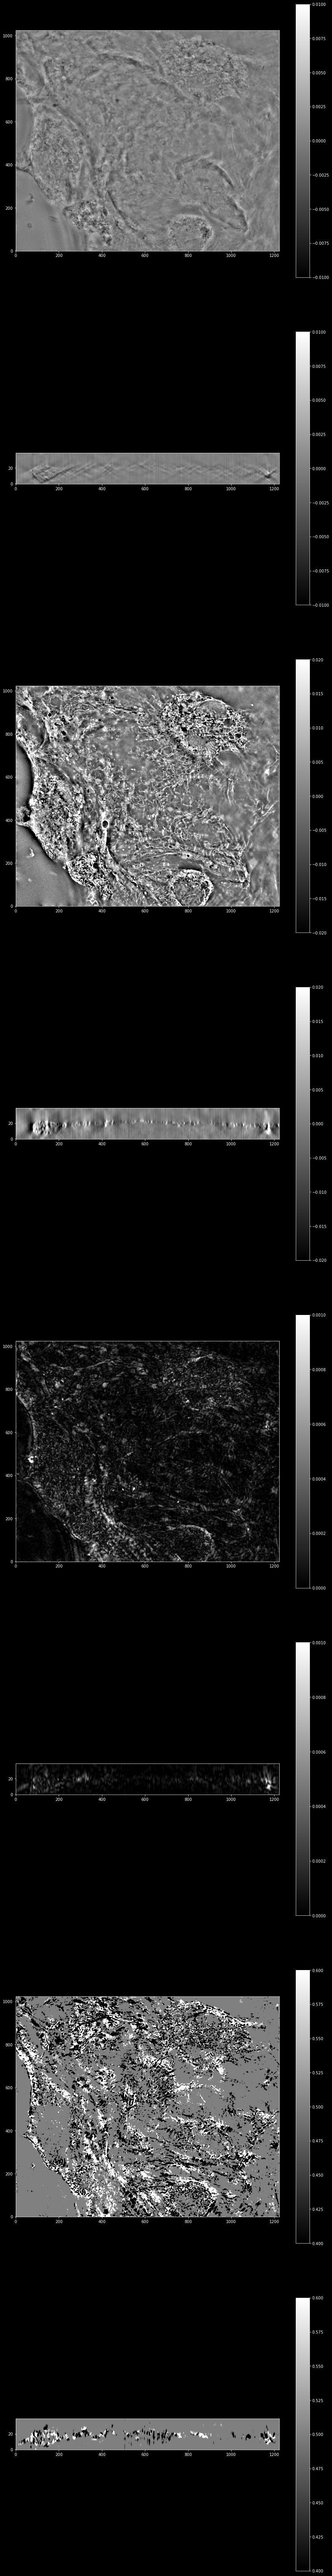

In [17]:
# Visualize the results

z_layer = 20
y_layer = 612

phase_min = -0.02
phase_max = 0.02
abs_min = -0.01
abs_max = 0.01
ret_min = 0
ret_max = 0.001
p_min = 0.4
p_max = 0.6


fig,ax = plt.subplots(8,1,figsize=(15,120))
sub_ax = ax[0].imshow(absorption_PT[:,:,z_layer], cmap='gray', origin='lower', vmin=abs_min, vmax=abs_max)
plt.colorbar(sub_ax, ax=ax[0])
sub_ax = ax[1].imshow(np.transpose(absorption_PT[y_layer,:,:]), cmap='gray', origin='lower',vmin=abs_min, vmax=abs_max, aspect=z_step/ps)
plt.colorbar(sub_ax, ax=ax[1])
sub_ax = ax[2].imshow(phase_PT[:,:,z_layer], cmap='gray', origin='lower', vmin=phase_min, vmax=phase_max)
plt.colorbar(sub_ax, ax=ax[2])
sub_ax = ax[3].imshow(np.transpose(phase_PT[y_layer,:,:]), cmap='gray', origin='lower',vmin=phase_min, vmax=phase_max, aspect=z_step/ps)
plt.colorbar(sub_ax, ax=ax[3])
sub_ax = ax[4].imshow(np.abs(retardance_pr_PT[0,:,:,z_layer]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max)
plt.colorbar(sub_ax, ax=ax[4])
sub_ax = ax[5].imshow(np.transpose(np.abs(retardance_pr_PT[0,y_layer,:,:])), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max, aspect=z_step/ps)
plt.colorbar(sub_ax, ax=ax[5])
sub_ax = ax[6].imshow(p_mat_map[:,:,z_layer], cmap='gray', origin='lower',vmin=p_min, vmax=p_max)
plt.colorbar(sub_ax, ax=ax[6])
sub_ax = ax[7].imshow(np.transpose(p_mat_map[y_layer,:,:]), cmap='gray', origin='lower',vmin=p_min, vmax=p_max, aspect=z_step/ps)
plt.colorbar(sub_ax, ax=ax[7])



### Render 3D orientation with 3D colorsphere (azimuth and inclination)

In [18]:
# create color-coded orientation images

ret_min_color = 0
ret_max_color = 0.0006

orientation_3D_image = np.transpose(np.array([azimuth[0]/2/np.pi, theta[0], (np.clip(np.abs(retardance_pr_PT[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]),(3,1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)


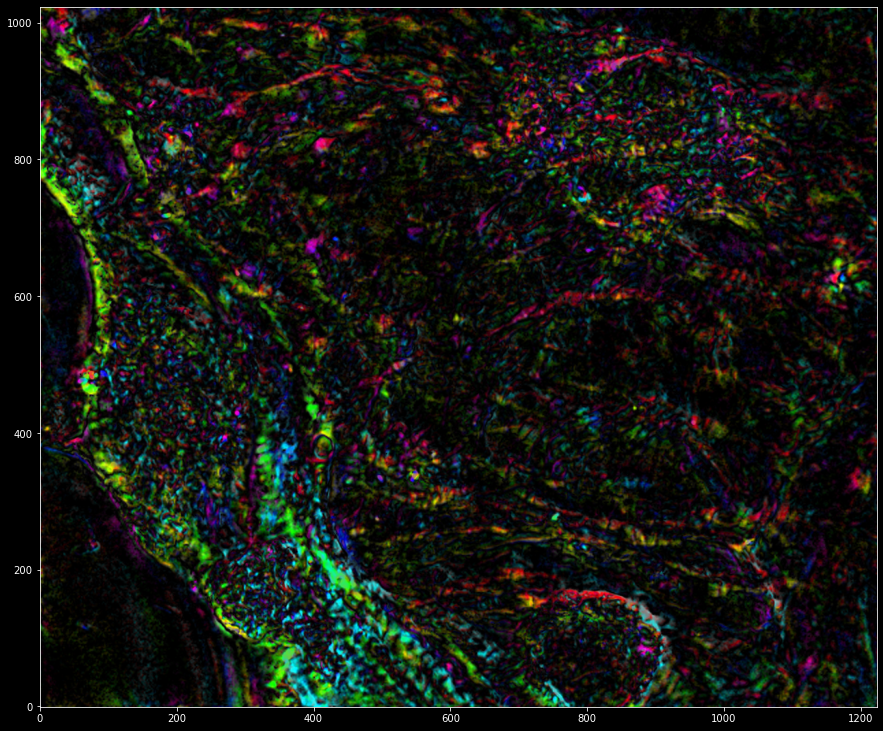

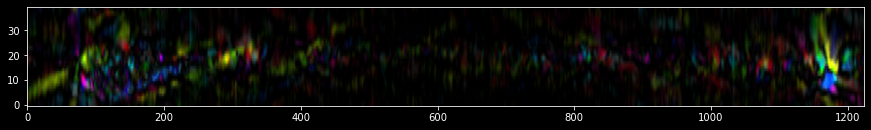

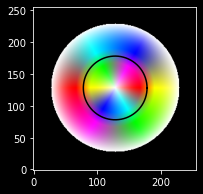

In [19]:
plt.figure(figsize=(15,15))
plt.imshow(orientation_3D_image_RGB[z_layer], origin='lower')
plt.figure(figsize=(15,15))
plt.imshow(orientation_3D_image_RGB[:,y_layer], origin='lower',aspect=z_step/ps)

# plot the top view of 3D orientation colorsphere
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

### Render 3D orientation with 2 channels (in-plane orientation and out-of-plane tilt)

In [20]:
# in-plane orientation
from matplotlib.colors import hsv_to_rgb

I_hsv = np.transpose(np.array([(azimuth[0])%np.pi/np.pi, \
                               np.ones_like(retardance_pr_PT[0]), \
                               (np.clip(np.abs(retardance_pr_PT[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (3,1,2,0))
in_plane_orientation = hsv_to_rgb(I_hsv.copy())

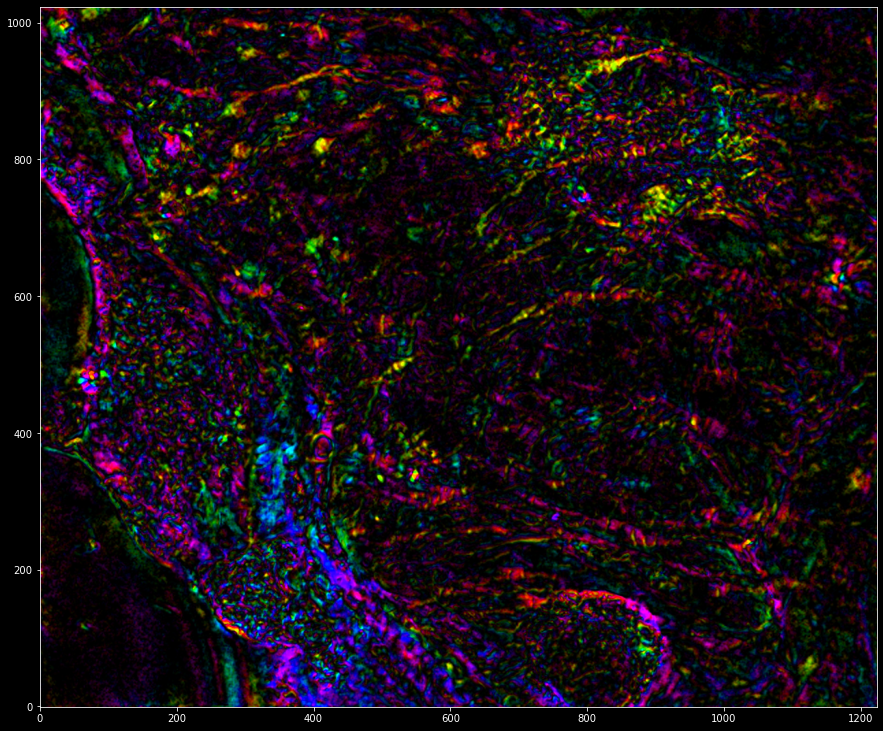

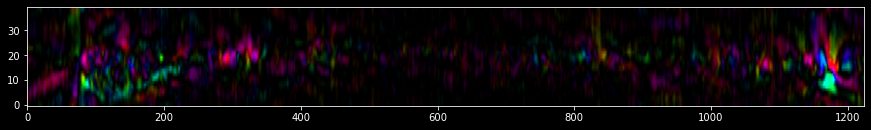

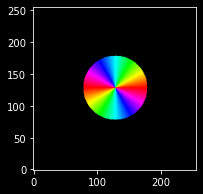

In [21]:
plt.figure(figsize=(15,15))
plt.imshow(in_plane_orientation[z_layer], origin='lower')
plt.figure(figsize=(15,15))
plt.imshow(in_plane_orientation[:,y_layer], origin='lower',aspect=z_step/ps)
plt.figure(figsize=(3,3))
wo.orientation_2D_colorwheel()

In [22]:
# out-of-plane tilt

threshold_inc = np.pi/90

I_hsv = np.transpose(np.array([(-np.maximum(0,np.abs(theta[0]-np.pi/2)-threshold_inc)+np.pi/2+threshold_inc)/np.pi, \
                               np.ones_like(retardance_pr_PT[0]), \
                               (np.clip(np.abs(retardance_pr_PT[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (3,1,2,0))
out_of_plane_tilt = hsv_to_rgb(I_hsv.copy())

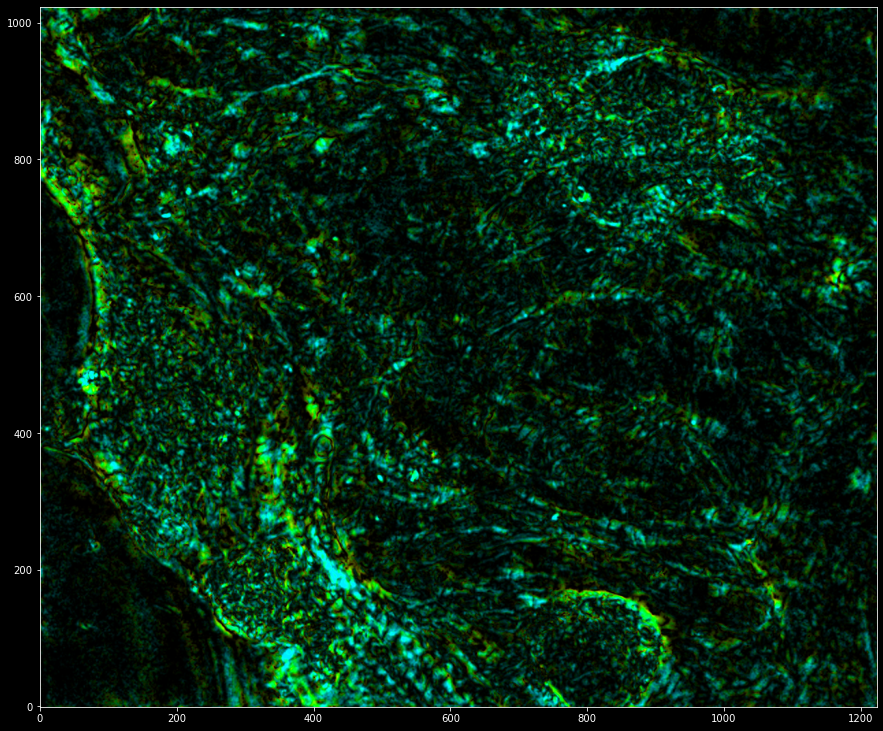

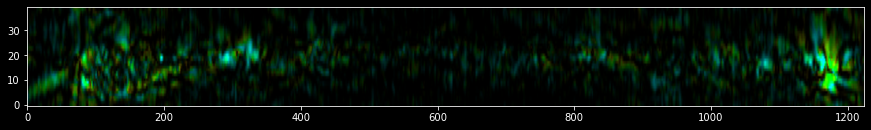

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(out_of_plane_tilt[z_layer], origin='lower')
plt.figure(figsize=(15,15))
plt.imshow(out_of_plane_tilt[:,y_layer], origin='lower',aspect=z_step/ps)

## Sub-FOV analysis

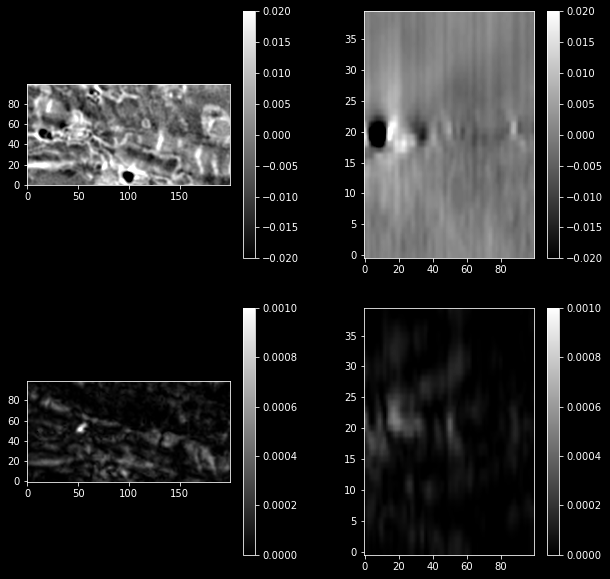

In [25]:

### FOV 1
idx_crop = [225,700]
num_crop = [100,200]

z_crop = [0,40]
z_layer = 20


phase_crop = phase_PT[idx_crop[0]:idx_crop[0]+num_crop[0],idx_crop[1]:idx_crop[1]+num_crop[1],z_crop[0]:z_crop[1]]
ret_crop = retardance_pr_PT[0,idx_crop[0]:idx_crop[0]+num_crop[0],idx_crop[1]:idx_crop[1]+num_crop[1],z_crop[0]:z_crop[1]]
azimuth_crop = azimuth[0,idx_crop[0]:idx_crop[0]+num_crop[0],idx_crop[1]:idx_crop[1]+num_crop[1],z_crop[0]:z_crop[1]]
theta_crop = theta[0,idx_crop[0]:idx_crop[0]+num_crop[0],idx_crop[1]:idx_crop[1]+num_crop[1],z_crop[0]:z_crop[1]]
p_mat_map_crop = p_mat_map[idx_crop[0]:idx_crop[0]+num_crop[0],idx_crop[1]:idx_crop[1]+num_crop[1],z_crop[0]:z_crop[1]]

fig,ax = plt.subplots(2,2,figsize=(10,10))
sub_ax = ax[0,0].imshow(np.real(phase_crop[:,:,z_layer]), cmap='gray', origin='lower', vmin=phase_min, vmax=phase_max)
plt.colorbar(sub_ax, ax=ax[0,0])
sub_ax = ax[0,1].imshow(np.transpose(phase_crop[:,100,:]), cmap='gray', origin='lower',vmin=phase_min, vmax=phase_max, aspect=z_step/ps)
plt.colorbar(sub_ax, ax=ax[0,1])
sub_ax = ax[1,0].imshow(np.real(ret_crop[:,:,z_layer]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max)
plt.colorbar(sub_ax, ax=ax[1,0])
sub_ax = ax[1,1].imshow(np.transpose(ret_crop[:,100,:]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max, aspect=z_step/ps)
plt.colorbar(sub_ax, ax=ax[1,1])

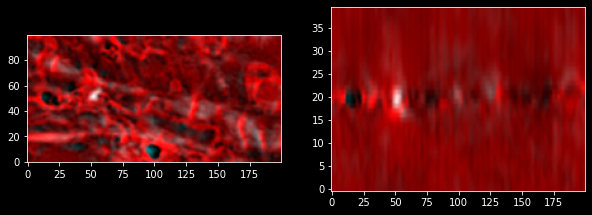

In [27]:
I_render = np.zeros((num_crop[0], num_crop[1], z_crop[1]-z_crop[0], 3))
I_ret = np.clip(ret_crop,0,0.0012)
I_ret /= np.max(I_ret)
I_ph = np.clip(phase_crop,-0.02,0.02)+0.02
I_ph /= np.max(I_ph)
for i, array in enumerate([I_ph, I_ret, I_ret]): I_render[:,:,:,i] = array.copy()*255
I_render = np.uint8(I_render)

fig,ax = plt.subplots(1,2,figsize=(10,5))
sub_ax = ax[0].imshow(I_render[:,:,z_layer], origin='lower')
sub_ax = ax[1].imshow(np.transpose(I_render[50,:,:],(1,0,2)), origin='lower', aspect=z_step/ps)

(<Figure size 360x360 with 1 Axes>, <PolarAxesSubplot:>)

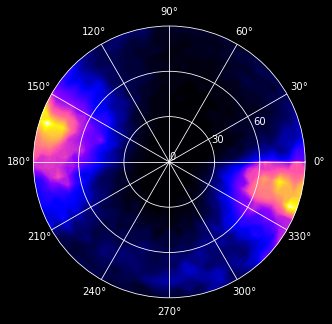

In [28]:
# 3D orientation histograms for the structure and permittivity tensor

mask = np.abs(ret_crop[0].copy())
mask[mask<0.0001]=0
mask[mask>=0.0001]=1

az =  azimuth_crop.flatten()
th = theta_crop.flatten()
val = np.abs(ret_crop*mask).flatten()
wo.orientation_3D_hist(az, th, val, bins=36, num_col=1, size=5, contour_level = 100, hist_cmap='gnuplot2',top_hemi=True, colorbar=False)


## Load fluorescence data

In [29]:
# Load fluorescence data
fluor_file_name = 'Cardiomyocytes_infected_1_fluor_decon.zarr'
reader_fluor = WaveorderReader(fluor_file_name, 'zarr')
I_fluor = np.squeeze(np.transpose(reader_fluor.get_array(0),(0,1,3,4,2)))


In [32]:
I_rgb = np.zeros((N_full, M_full, N_defocus, 3))
I_rgb[:,:,:,1] = np.clip((I_fluor[1])**0.8/np.max((I_fluor[1])**0.8)*255*6,0,255)
I_rgb[:,:,:,2] = np.clip(I_fluor[0]/np.max(I_fluor[0])*255*1.5,0,255)
I_rgb[:,:,:,:] += np.tile(np.clip(I_fluor[2]/np.max(I_fluor[2])*255*3,0,255)[:,:,:,np.newaxis],(1,1,1,3))
I_rgb = np.uint8(np.clip(I_rgb, 0, 255))
                

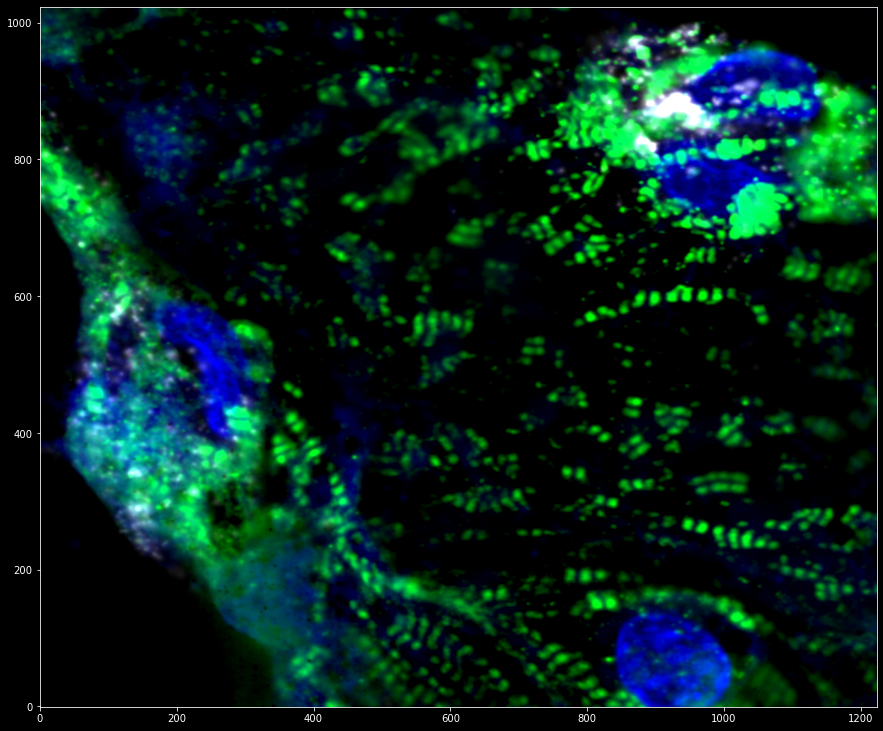

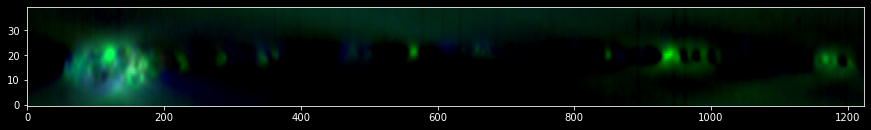

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(I_rgb[:,:,z_layer], origin='lower')
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(I_rgb[y_layer],(1,0,2)), origin='lower', aspect=z_step/ps)